In [10]:
import random
import pandas as pd
import numpy as np

# Matriz de adyacencia para el grafo
E = [(1, 2), (1, 4), (1, 16),
     (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7),
     (3, 2), (3, 7), (3, 11), (3, 19),
     (4, 1), (4, 2), (4, 5), (4, 8), (4, 9),
     (5, 2), (5, 4), (5, 6), (5, 9), (5, 10),
     (6, 2), (6, 5), (6, 7), (6, 11), (6, 14),
     (7, 2), (7, 3), (7, 6), (7, 11),
     (8, 4), (8, 9), (8, 12), (8, 16),
     (9, 4), (9, 5), (9, 8), (9, 10), (9, 12), (9, 13), (9, 15),
     (10, 5), (10, 9), (10, 13), (10, 14),
     (11, 3), (11, 6), (11, 7), (11, 14), (11, 19),
     (12, 8), (12, 9), (12, 15), (12, 16),
     (13, 9), (13, 10), (13, 14), (13, 15), (13, 17), (13, 18),
     (14, 6), (14, 10), (14, 11), (14, 13), (14, 18), (14, 19),
     (15, 9), (15, 12), (15, 13), (15, 16), (15, 17),
     (16, 1), (16, 8), (16, 12), (16, 15), (16, 17),
     (17, 13), (17, 15), (17, 16), (17, 18), (17, 19),
     (18, 13), (18, 14), (18, 17), (18, 19),
     (19, 3), (19, 11), (19, 14), (19, 17), (19, 18)]

# Crear la matriz de adyacencia
df = np.zeros((19, 19))
for row, col in E:
    df[row - 1, col - 1] = 1
df = pd.DataFrame(df, columns=range(1, 20), index=range(1, 20))

# Parámetros del algoritmo genético
population_size = 50
num_genes = 19
max_generations = 100
crossover_probability = 0.9
mutation_probability = 0.1
elitism = True  # Criterio de reemplazo: Elitismo

In [11]:
class Agent:
    def __init__(self, df, num_genes=19):
        self.df = df
        self.num_genes = num_genes
        self.random_initialization()
        self.fitness = self.calc_fitness()

    def random_initialization(self):
        # Criterio de inicialización: Genera un cromosoma aleatorio y asegura factibilidad
        self.chromosome = [random.choice(range(1, self.num_genes + 1)) for _ in range(self.num_genes)]
        self.create_pairs()
        while not self.check_factibility():
            self.chromosome = [random.choice(range(1, self.num_genes + 1)) for _ in range(self.num_genes)]
            self.create_pairs()

    def check_factibility(self):
        # Función de factibilidad: Verifica que dos nodos conectados no tengan el mismo color
        for pair in self.pairs:
            connections = self.df.loc[pair[0]][self.df.loc[pair[0]] == 1].index.tolist()
            for connection in connections:
                if pair[1] == self.pairs[connection - 1][1]:
                    return False
        return True

    def create_pairs(self):
        # Crear una lista de pares de posición y valor
        self.pairs = [[i + 1, self.chromosome[i]] for i in range(len(self.chromosome))]

    def calc_fitness(self):
        penalty = 0
        for pair in self.pairs:
            connections = self.df.loc[pair[0]][self.df.loc[pair[0]] == 1].index.tolist()
            for connection in connections:
                if pair[1] == self.pairs[connection - 1][1]:
                    penalty += 1
        return -len(set(self.chromosome)) # - penalty


    def mutate(self):
        # Mutación: Realiza una mutación en un gen del cromosoma
        idx = random.randint(0, self.num_genes - 1)
        self.chromosome[idx] = random.randint(1, self.num_genes)
        self.create_pairs()
        while not self.check_factibility():
            idx = random.randint(0, self.num_genes - 1)
            self.chromosome[idx] = random.randint(1, self.num_genes)
            self.create_pairs()
        self.fitness = self.calc_fitness()

    def crossover(self, partner):
        # Cruce: Realiza un cruce de un punto entre dos cromosomas
        if random.random() < crossover_probability:
            crossover_point = random.randint(1, self.num_genes - 2)
            child1_chromosome = self.chromosome[:crossover_point] + partner.chromosome[crossover_point:]
            child2_chromosome = partner.chromosome[:crossover_point] + self.chromosome[crossover_point:]

            # Crear hijos y verificar factibilidad
            child1 = Agent(self.df, self.num_genes)
            child2 = Agent(self.df, self.num_genes)
            child1.chromosome = child1_chromosome
            child2.chromosome = child2_chromosome
            child1.create_pairs()
            child2.create_pairs()

            # Verificar factibilidad y retorno de hijos factibles
            if child1.check_factibility() and child2.check_factibility():
                child1.fitness = child1.calc_fitness()
                child2.fitness = child2.calc_fitness()
                return child1, child2 # Retorna ambos hijos solo si ambos son factibles
            elif child1.check_factibility():
                child1.fitness = child1.calc_fitness()
                return child1, partner # Retorna child1 si solo él es factible
            elif child2.check_factibility():
                child2.fitness = child2.calc_fitness() # Retorna child2 si solo él es factible
                return child2, self
            else:
                return self, partner # Si ninguno es factible, retorna los padres originales
        else:
            return self, partner # Si no hay cruce, retorna los padres originales

In [12]:
def selection(population):
    # Criterio de selección: Selección por torneo
    selected = []
    for _ in range(len(population)):
        ind1 = random.choice(population)
        ind2 = random.choice(population)
        selected.append(ind1 if ind1.fitness > ind2.fitness else ind2)
    return selected

def replacement(old_population, new_population):
    # Criterio de reemplazo: Elitismo
    if elitism:
        combined = old_population + new_population
        combined.sort(key=lambda x: x.fitness, reverse=True)
        return combined[:population_size]
    else:
        return new_population

In [13]:
yo = Agent(df)
print(yo.chromosome)
for pair in yo.pairs:
    connections = df.loc[pair[0]][df.loc[pair[0]] == 1].index.tolist()
    for connection in connections:
        if pair[1] == yo.pairs[connection - 1][1]:
            print('Repeated color:', pair[0], connection)
            print('Color:', pair[1])

[12, 13, 3, 3, 8, 19, 15, 19, 2, 14, 6, 16, 9, 16, 18, 4, 2, 14, 11]


In [14]:
#Get unique values from the chromosome
unique = []
for i in yo.chromosome:
    if i not in unique:
        unique.append(i)  # Agrega colores únicos a la lista
print(len(unique))  # Imprime la cantidad de colores únicos (cuantos menos, mejor)
yo.fitness  # Muestra el fitness del agente


14


-14

In [15]:
population = [Agent(df, num_genes) for _ in range(population_size)]
best_fitness = max([agent.fitness for agent in population])

for generation in range(max_generations):
    new_population = []

    selected = selection(population)

    # Cruce
    for i in range(0, population_size, 2):
        parent1 = selected[i]
        parent2 = selected[i + 1]
        child1, child2 = parent1.crossover(parent2)
        new_population.extend([child1, child2])

    # Mutación
    for individual in new_population:
        if random.random() < mutation_probability:
            individual.mutate()

    # Reemplazo
    population = replacement(population, new_population)

    # Criterio de paro: Si se llega al número máximo de generaciones o si se encuentra la mejor solución posible
    best_fitness = max([agent.fitness for agent in population])
    print(f"Generation {generation}: Best Fitness: {best_fitness}")

# Resultado final
best_agent = max(population, key=lambda agent: agent.fitness)
print("Best chromosome:", best_agent.chromosome)
print("Best fitness:", best_agent.fitness)

Generation 0: Best Fitness: -11
Generation 1: Best Fitness: -10
Generation 2: Best Fitness: -10
Generation 3: Best Fitness: -9
Generation 4: Best Fitness: -9
Generation 5: Best Fitness: -9
Generation 6: Best Fitness: -9
Generation 7: Best Fitness: -9
Generation 8: Best Fitness: -9
Generation 9: Best Fitness: -8
Generation 10: Best Fitness: -8
Generation 11: Best Fitness: -8
Generation 12: Best Fitness: -8
Generation 13: Best Fitness: -8
Generation 14: Best Fitness: -8
Generation 15: Best Fitness: -8
Generation 16: Best Fitness: -8
Generation 17: Best Fitness: -8
Generation 18: Best Fitness: -8
Generation 19: Best Fitness: -7
Generation 20: Best Fitness: -7
Generation 21: Best Fitness: -7
Generation 22: Best Fitness: -7
Generation 23: Best Fitness: -7
Generation 24: Best Fitness: -7
Generation 25: Best Fitness: -7
Generation 26: Best Fitness: -7
Generation 27: Best Fitness: -7
Generation 28: Best Fitness: -7
Generation 29: Best Fitness: -7
Generation 30: Best Fitness: -7
Generation 31: 

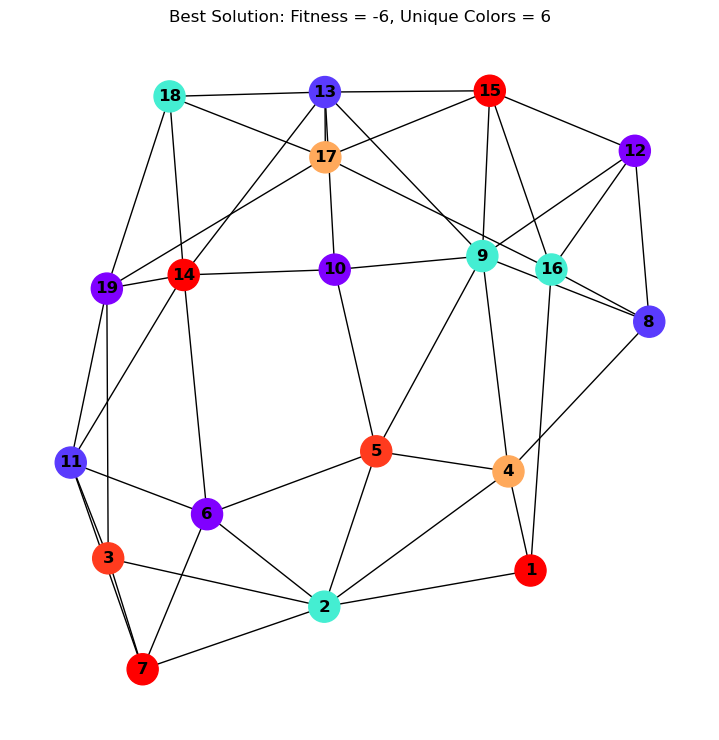

In [43]:
import matplotlib.pyplot as plt
import networkx as nx

# Crear el grafo
G = nx.Graph()

# Agregar nodos y colorearlos según el cromosoma
colors = [best_agent.chromosome[i-1] for i in range(1, 20)]  # Asignar colores basados en el cromosoma
G.add_nodes_from(range(1, 20))

# Agregar bordes basados en la matriz de adyacencia
G.add_edges_from(E)

# Dibujar el grafo
plt.figure(figsize=(7,7))
pos = nx.spring_layout(G)  # Layout del grafo
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=500, cmap=plt.cm.rainbow, edge_color='black', font_weight='bold', font_color='black')
plt.title(f"Best Solution: Fitness = {best_agent.fitness}, Unique Colors = {len(set(best_agent.chromosome))}")
plt.show()
